# Project 5: The Enron Dataset

Robert Lee

There are 146 people in the Enron Dataset, 21 features each, 18 POI (persons of interest) 

In [41]:
#!/usr/bin/python

import sys
import pickle

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import grid_search 
from time import time

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
features_list = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']
# You will need to use more features, 8 existing features, 3 new ones I created

### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

import pprint

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

I use 8 existing features, and create 3 more (the last 3)
features_list = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']

In [42]:
features_list = ['poi','salary','total_stock_value','exercised_stock_options','from_poi_to_this_person','from_this_person_to_poi','from_messages','to_messages','ratio_to_poi','ratio_from_poi','ratio_exercised']

Here is one entry in the dictionary, key: 'ALLEN PHILLIP K'

In [43]:
pprint.pprint(data_dict['ALLEN PHILLIP K'])

{'bonus': 4175000,
 'deferral_payments': 2869717,
 'deferred_income': -3081055,
 'director_fees': 'NaN',
 'email_address': 'phillip.allen@enron.com',
 'exercised_stock_options': 1729541,
 'expenses': 13868,
 'from_messages': 2195,
 'from_poi_to_this_person': 47,
 'from_this_person_to_poi': 65,
 'loan_advances': 'NaN',
 'long_term_incentive': 304805,
 'other': 152,
 'poi': False,
 'restricted_stock': 126027,
 'restricted_stock_deferred': -126027,
 'salary': 201955,
 'shared_receipt_with_poi': 1407,
 'to_messages': 2902,
 'total_payments': 4484442,
 'total_stock_value': 1729541}


Length of dictionary (number of people) and length of one of the entries == # of features

In [44]:
print len(data_dict)
print len(data_dict['ALLEN PHILLIP K'])

146
21


### Task 2: Remove outliers

Three of the "people" in the dictionary are not people, but bad data to be removed

"TOTAL" appears to be a summary statistic.
"TRAVEL AGENCY IN THE PARK" appears to be a contractor that was paid a sum of money.
"LOCKHART EUGENE E" has all NaN values. Harmless, but I go ahead and remove it.

I don't remove data outliers, because they are probably important data (the big shot executives making a lot of money and communicating a lot with each other).

In [108]:
data_dict.pop('TOTAL', 0)
data_dict.pop('TRAVEL AGENCY IN THE PAR', 0)
data_dict.pop('LOCKHART EUGENE E', 0)
print "Three entries popped"
len(data_dict)

Three entries popped


144

### I look for 'poi = TRUE to count the number of persons of interest

In [46]:
n=0
for each in data_dict:
    if data_dict[each]['poi']:
        n+=1
print n

18


### Task 3: Create new feature(s)
The 3 new features are:
ratio_exercised, ratio_to_poi, ratio_from_poi

(1) ratio_exercised = exercised_stock_options / total_stock_value
I created this feature to reflect how much stock the person exercised out of their total (from 0 to 1). I figured that people who were in on the scam might have exercised more of their options, knowing that it was a house of cards. On the other hand, a middle-class person who was not in on the scam might also exercise their options, given the high share price (honest desire to cash in).

(2) ratio_to_poi = from_this_person_to_poi / to_messages
Another 0 to 1 ratio. The absolute number of emails to a POI is less meaningful than the ratio of their messages to POI.

(3) ratio_to_poi = from_poi_to_this_person / from_messages
Another 0 to 1 ratio. The absolute number of emails from a POI is less meaningful than the ratio of messages from a POI.

I first eliminate NaN and bad values (any of numerator < 0, any denominator <= 0)

In [47]:
def new_feature(numerator,denominator):
    new_feature=[]

    for i in data_dict:
        if data_dict[i][numerator]=="NaN" or data_dict[i][denominator]=="NaN":
            new_feature.append("NaN")
        elif data_dict[i][numerator]<0 or data_dict[i][denominator]<=0:
            new_feature.append("NaN")
        else:
            new_feature.append(float(data_dict[i][numerator]) / data_dict[i][denominator])
    return new_feature

### create lists of new features
ratio_exercised=new_feature("exercised_stock_options","total_stock_value")
ratio_to_poi=new_feature("from_poi_to_this_person","to_messages")
ratio_from_poi=new_feature("from_this_person_to_poi","from_messages")

### insert new features into data_dict
count=0
for i in data_dict:
    data_dict[i]["ratio_exercised"] = ratio_exercised[count]
    data_dict[i]["ratio_to_poi"] = ratio_to_poi[count]
    data_dict[i]["ratio_from_poi"] = ratio_from_poi[count]
    count +=1

### store to my_dataset for easy export below
my_dataset = data_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)

labels, features = targetFeatureSplit(data)

In [48]:
data = featureFormat(my_dataset, features_list, sort_keys = True)

labels, features = targetFeatureSplit(data)

# Plot new features to get a feel for them
## ratio_exercised

Ratio of stock options exercised is betwen 0 (none exercised) up to about 20%

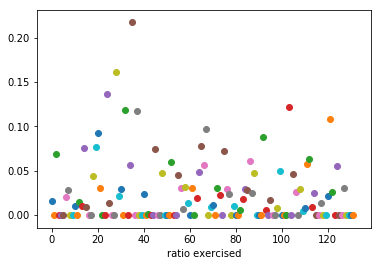

In [49]:
n=0
for point in data:
    ratio_exercised = point[8]
    plt.scatter( n, ratio_exercised )
    n+=1
plt.xlabel("ratio exercised")
plt.show()

## ratio_to_poi

Ratio of all emails sent to POI

Between 0 and 1.0.

The one 1.0 data point is suspiciously high, so I print one that point above the plot. This person was not a PIO, had a salary of 130K, had significant stock, sent 10 emails to POI, received 17 emails from POI, sent 17 total emails, and received 128 total emails. So this data point does not seem outlanding. In addition, since this feature is not in my top 5 best (see below), I am not too concerned with this 1.0 value.

In [58]:
n=0
for point in data:
    ratio_to_poi  = point[9]
    if ratio_to_poi == 1.0:
        print point
    plt.scatter( n, ratio_to_poi )
    n+=1
plt.xlabel("ratio of all emails sent to POI")
plt.show()

[  0.00000000e+00   1.30724000e+05   2.28276800e+06   2.28276800e+06
   1.00000000e+01   1.70000000e+01   1.70000000e+01   1.28000000e+02
   7.81250000e-02   1.00000000e+00   1.00000000e+00]


## ratio_from_poi

Ratio of all emails from POI

Between 0 and 1.0.

There are a lot of 1.0 data points. So either the data is generally pretty bad, or else these 1.0 values are valid. I'll go with the latter assumption, though of course I could investigate more.

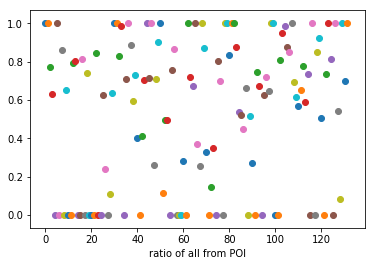

In [60]:
n=0
for point in data:
    ratio_from_poi  = point[10]
    plt.scatter( n, ratio_from_poi )
    n+=1
plt.xlabel("ratio of all from POI")
plt.show()

### Getting a sense of most highly correlated feature with SelectKBest()
I print out the best 5 features from two data points. I print the corresponding entire set of feature for each of these so I can compare and figure out which features these are (data does not have any dictionary keys)

The best 5 features, in order are:

salary

total_stock_value

exercised_stock_options

from_this_person_to_poi

ratio_from_poi

Only one of my new features, ratio_from_poi, made it into the top 5. I could go back and try to create better features, much less do PCA, but I won't change these for now.

In [80]:
K_best = SelectKBest(k=5)
# Use that instance to extract the best features:
features_kbest = K_best.fit_transform(features, labels)
print "Shape of features after applying SelectKBest -> ", features_kbest.shape
print data_dict["ALLEN PHILLIP K"]
print features_kbest[0]
print features[0]
print data_dict["BANNANTINE JAMES M"]
print features_kbest[2]
print features[2]

Shape of features after applying SelectKBest ->  (132, 5)
{'to_messages': 2902, 'deferral_payments': 2869717, 'expenses': 13868, 'poi': False, 'deferred_income': -3081055, 'email_address': 'phillip.allen@enron.com', 'long_term_incentive': 304805, 'restricted_stock_deferred': -126027, 'shared_receipt_with_poi': 1407, 'loan_advances': 'NaN', 'from_messages': 2195, 'other': 152, 'director_fees': 'NaN', 'bonus': 4175000, 'total_stock_value': 1729541, 'from_poi_to_this_person': 47, 'ratio_to_poi': 0.016195727084769126, 'from_this_person_to_poi': 65, 'restricted_stock': 126027, 'salary': 201955, 'ratio_exercised': 1.0, 'total_payments': 4484442, 'exercised_stock_options': 1729541, 'ratio_from_poi': 0.029612756264236904}
[  2.01955000e+05   1.72954100e+06   1.72954100e+06   4.70000000e+01
   2.96127563e-02]
[  2.01955000e+05   1.72954100e+06   1.72954100e+06   4.70000000e+01
   6.50000000e+01   2.19500000e+03   2.90200000e+03   1.61957271e-02
   2.96127563e-02   1.00000000e+00]
{'to_messages'

### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

## Training vs Testing (Validation)
I used cross_validation with a test size of 0.1 with my classifiers.

features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

In [63]:
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features, labels, test_size=0.1, random_state=42)

# Trying GaussianNB() with default arguments

In [109]:
def classify_NB(features_train, labels_train):
    
    ### your code goes here--should return a trained decision tree classifer
    
    clf = GaussianNB()
    clf.fit(features_train, labels_train)
    return clf
    
clf = classify_NB(features_train, labels_train)
pred = clf.predict(features_test)
print "NB: accuracy, precision, recall, F1"
print accuracy_score(pred,labels_test)
print precision_score(pred,labels_test)
print recall_score(pred,labels_test)
print f1_score(pred,labels_test)

NB: accuracy, precision, recall, F1
0.785714285714
0.333333333333
0.5
0.4


# Trying DecisionTreeClassifier() with default arguments

In [65]:
def classify_DTC(features_train, labels_train):
    
    ### your code goes here--should return a trained decision tree classifer
    
    clf = DecisionTreeClassifier()
    clf.fit(features_train, labels_train)
    return clf
    
clf = classify_DTC(features_train, labels_train)
pred = clf.predict(features_test)
print "DTC: accuracy, precision, recall, F1"
print accuracy_score(pred,labels_test)
print precision_score(pred,labels_test)
print recall_score(pred,labels_test)
print f1_score(pred,labels_test)

DTC: accuracy, precision, recall, F1
0.714285714286
0.333333333333
0.333333333333
0.333333333333


# Trying DecisionTreeClassifier() with default arguments

N = 5 looks really good, I think our ULTIMATE winner will be a classifier similar to this

0.929 accuracy

0.666666666667 precision

1.0 recall

0.8 F1

In [66]:
def classify_knn(features_train,labels_train,n):
    neigh = KNeighborsClassifier(n)
    neigh.fit(features_train, labels_train)
    return neigh

def classit_knn(n):
    return classify_knn(features_train, labels_train, n)

def pred_knn(n):
    return classit_knn(n).predict(features_test)

pred_2 = accuracy_score(pred_knn(2),labels_test)
pred_5 = accuracy_score(pred_knn(5),labels_test)
pred_8 = accuracy_score(pred_knn(8),labels_test)
print "KNN: accuracy, precision, recall, F1"
print "n:2"
print round(pred_2,3)
print precision_score(pred_knn(2),labels_test)
print recall_score(pred_knn(2),labels_test)
print f1_score(pred_knn(2),labels_test)
print "n:5"
print round(pred_5,3)
print precision_score(pred_knn(5),labels_test)
print recall_score(pred_knn(5),labels_test)
print f1_score(pred_knn(5),labels_test)
print "n:8"
print round(pred_8,3)
print precision_score(pred_knn(8),labels_test)
print recall_score(pred_knn(8),labels_test)
print f1_score(pred_knn(8),labels_test)

KNN: accuracy, precision, recall, F1
n:2
0.857
0.333333333333
1.0
0.5
n:5
0.857
0.333333333333
1.0
0.5
n:8
0.786
0.0
0.0
0.0


/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/Users/robertlee/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


### Task 5: Tune your classifier to achieve better than .3 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

## I do a grid search on KNN, evaluating by F1 score.

knn =  KNeighborsClassifier()

scaler = MinMaxScaler()

select = SelectKBest(k=3)
 
sss = StratifiedShuffleSplit(n_splits = 100, random_state=42)

pipe = Pipeline(steps=[('scaling', scaler), ('feature_selection', select), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

In [82]:
knn =  KNeighborsClassifier()
scaler = MinMaxScaler()
select = SelectKBest(k=3)
 
sss = StratifiedShuffleSplit(n_splits = 100, random_state=42)

pipe = Pipeline(steps=[('scaling', scaler), ('feature_selection', select), ("knn", knn)])

param_grid = {"knn__n_neighbors": [1, 3, 5, 8, 10, 12, 14],
              "knn__algorithm": ["auto","ball_tree", "kd_tree", "brute"],
              "knn__leaf_size": range(3,10,1),
              "knn__p": [1,2]
             }

knnclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
knnclf.fit(features, labels)
bestknn = knnclf.best_estimator_
print "Best KNN"
print bestknn

Best KNN
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=3, score_func=<function f_classif at 0x1179bc758>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])


The resulting best KNN classified under these parameters is:

KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')
           
And the scores are:

KNN grid: accuracy, precision, recall, F1

0.857142857143 accuracy

0.333333333333 precision

1.0 recall

0.5 F1

0.5 is not a bad F1 score. I could likely do better if I played around with the grid search parameters a bit, but this is not bad.

In [83]:
KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

best.fit(features_train, labels_train)
pred = best.predict(features_test)
print "KNN grid: accuracy, precision, recall, F1"
print accuracy_score(pred,labels_test)
print precision_score(pred,labels_test)
print recall_score(pred,labels_test)
print f1_score(pred,labels_test)

KNN grid: accuracy, precision, recall, F1
0.857142857143
0.333333333333
1.0
0.5


## I do a grid search on DecisionTreeClassifier(), evaluating by F1 score.

In [88]:
dtree =  DecisionTreeClassifier()
scaler = MinMaxScaler()
sss = StratifiedShuffleSplit(n_splits = 100, random_state=42)
select = SelectKBest(k=3)


pipe =  Pipeline(steps=[('scaling',scaler),('feature_selection', select), ("dt", dtree)])

param_grid = {"dt__criterion": ["entropy"],
              "dt__min_samples_split": [2, 4, 6],
              "dt__max_depth": [2, 4, 6],
              "dt__min_samples_leaf": [2, 4, 6],
              "dt__max_leaf_nodes": [2, 4, 6],
              }

dtcclf = GridSearchCV(pipe, param_grid, scoring='f1', cv=sss)
dtcclf.fit(features, labels)
bestclf = dtcclf.best_estimator_
print "Best DTC"
print bestclf

Best DTC
Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=3, score_func=<function f_classif at 0x1179bc758>)), ('dt', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=6, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])


# I take the above best DTC classifier and print out the scores

DTC grid: accuracy, precision, recall, F1

Not as good as KNN.

0.785714285714 accuracy

0.333333333333 precision

0.5 recall 

0.4 F1

In [90]:
best = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=6, min_impurity_split=1e-07,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

best.fit(features_train, labels_train)
pred = best.predict(features_test)
print "DTC grid: accuracy, precision, recall, F1"
print accuracy_score(pred,labels_test)
print precision_score(pred,labels_test)
print recall_score(pred,labels_test)
print f1_score(pred,labels_test)

DTC grid: accuracy, precision, recall, F1
0.785714285714
0.333333333333
0.5
0.4


# RESULTS
## KNN grid search had better results, with a 0.5 best F1 score.

More experimentation with different parameters and/or different classifiers could improve this. But the results seems adequate / useful.

I used 0.1 as my test size. I can't really go lower than this, since there are only 18 POIS. A 0.1 test size means there are only a few POIs we are testing on. There is an argument that I should be using a larger test size.

KNN grid: accuracy, precision, recall, F1

0.857142857143 accuracy

0.333333333333 precision

1.0 recall

0.5 F1


DTC grid: accuracy, precision, recall, F1

0.785714285714 accuracy

0.333333333333 precision

0.5 recall 

0.4 F1


## Dumping classifer, dataset, and feature_list to .pkl

In [112]:
CLF_PICKLE_FILENAME = "my_classifier.pkl"
DATASET_PICKLE_FILENAME = "my_dataset.pkl"
FEATURE_LIST_FILENAME = "my_feature_list.pkl"

def dump_classifier_and_data(clf, dataset, feature_list):
    with open(CLF_PICKLE_FILENAME, "w") as clf_outfile:
        pickle.dump(clf, clf_outfile)
    with open(DATASET_PICKLE_FILENAME, "w") as dataset_outfile:
        pickle.dump(dataset, dataset_outfile)
    with open(FEATURE_LIST_FILENAME, "w") as featurelist_outfile:
        pickle.dump(feature_list, featurelist_outfile)
        
dump_classifier_and_data(bestknn, data_dict, features_list)

In [113]:
## Checking the written files

In [114]:
with open("my_classifier.pkl", "r") as file:
    clf = pickle.load(file)
print clf

Pipeline(steps=[('scaling', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feature_selection', SelectKBest(k=3, score_func=<function f_classif at 0x1179bc758>)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])


In [115]:
with open("my_dataset.pkl", "r") as file:
    data = pickle.load(file)
for person in data:
    print person, data[person]
    break

METTS MARK {'to_messages': 807, 'deferral_payments': 'NaN', 'expenses': 94299, 'poi': False, 'deferred_income': 'NaN', 'email_address': 'mark.metts@enron.com', 'from_poi_to_this_person': 38, 'restricted_stock_deferred': 'NaN', 'shared_receipt_with_poi': 702, 'loan_advances': 'NaN', 'from_messages': 29, 'other': 1740, 'director_fees': 'NaN', 'bonus': 600000, 'total_stock_value': 585062, 'ratio_to_poi': 0.04708798017348203, 'from_this_person_to_poi': 1, 'long_term_incentive': 'NaN', 'restricted_stock': 585062, 'salary': 365788, 'ratio_exercised': 'NaN', 'total_payments': 1061827, 'exercised_stock_options': 'NaN', 'ratio_from_poi': 0.034482758620689655}


In [116]:
with open("my_feature_list.pkl", "r") as file:
    features = pickle.load(file)
print features

['poi', 'salary', 'total_stock_value', 'exercised_stock_options', 'from_poi_to_this_person', 'from_this_person_to_poi', 'from_messages', 'to_messages', 'ratio_to_poi', 'ratio_from_poi', 'ratio_exercised']
